# 02 — Position Analysis

Build a Broken Wing Butterfly (BWB), analyze P&L and Greeks, and visualize with the Bloomberg theme.

The BWB is an excellent demo strategy: it has three legs, interesting Greeks dynamics, and is commonly traded in practice.

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Setup

Connect to TastyTrade paper and import engine/visualization modules.

In [2]:
from options_analyzer.config import load_config
from options_analyzer.adapters.tastytrade.session import TastyTradeSession
from options_analyzer.adapters.tastytrade.market_data import TastyTradeMarketDataProvider

config = load_config()

tt_session = TastyTradeSession(config.provider)
await tt_session.connect()
market_data = TastyTradeMarketDataProvider(tt_session)
print(f"Connected to TastyTrade ({'paper' if config.provider.is_paper else 'live'}).")

Connected to TastyTrade (live).


## 2. Build a BWB Position

Fetch the option chain, select strikes for a put BWB, and construct the position using domain models.

A **Broken Wing Butterfly** has 3 legs:
- Long 1 put at lower strike
- Short 2 puts at middle strike
- Long 1 put at higher strike (wider than the lower wing)

In [3]:
from datetime import UTC, datetime
from decimal import Decimal

from options_analyzer.domain.enums import OptionType, PositionSide
from options_analyzer.domain.models import Leg, OptionContract, Position

UNDERLYING = "SPY"

# Fetch chain and spot
chain = await market_data.get_option_chain(UNDERLYING)
spot_price = await market_data.get_underlying_price(UNDERLYING)
print(f"{UNDERLYING} spot: ${spot_price:.2f}")

# Pick a monthly expiration ~30-45 DTE
from datetime import date, timedelta
target_date = date.today() + timedelta(days=35)
sorted_exps = sorted(chain.keys())
exp_date = min(sorted_exps, key=lambda d: abs((d - target_date).days))
print(f"Selected expiration: {exp_date} ({(exp_date - date.today()).days} DTE)")

# Get puts, find ATM
contracts = chain[exp_date]
puts = sorted(
    [c for c in contracts if c.option_type == OptionType.PUT],
    key=lambda c: c.strike,
)
atm_strike = min(puts, key=lambda c: abs(c.strike - spot_price)).strike

# Build BWB: strikes below ATM
# Upper wing: ATM, Body: ATM - 5, Lower wing: ATM - 15 (broken)
upper_strike = atm_strike
body_strike = atm_strike - Decimal("5")
lower_strike = atm_strike - Decimal("15")  # Broken wing — wider gap

# Find matching contracts
put_by_strike = {c.strike: c for c in puts}
upper_contract = put_by_strike[upper_strike]
body_contract = put_by_strike[body_strike]
lower_contract = put_by_strike[lower_strike]

# Construct legs (using realistic mid-market prices as open prices)
bwb = Position(
    id="bwb-1",
    name=f"{UNDERLYING} {lower_strike}/{body_strike}/{upper_strike} Put BWB",
    underlying=UNDERLYING,
    legs=[
        Leg(contract=lower_contract, side=PositionSide.LONG, quantity=1, open_price=Decimal("1.50")),
        Leg(contract=body_contract, side=PositionSide.SHORT, quantity=2, open_price=Decimal("3.50")),
        Leg(contract=upper_contract, side=PositionSide.LONG, quantity=1, open_price=Decimal("7.00")),
    ],
    opened_at=datetime.now(tz=UTC),
)

print(f"\nPosition: {bwb.name}")
print(f"Net debit/credit: ${bwb.net_debit_credit:.2f}")
for leg in bwb.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    print(f"  {side:>5} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike} @ ${leg.open_price}")

SPY spot: $694.82
Selected expiration: 2026-03-20 (38 DTE)

Position: SPY 680.0/690.0/695.0 Put BWB
Net debit/credit: $150.00
   LONG 1x PUT 680.0 @ $1.50
  SHORT 2x PUT 690.0 @ $3.50
   LONG 1x PUT 695.0 @ $7.00


## 3. Expiration P&L

Compute the hockey-stick payoff diagram at expiration — the classic way to visualize an options strategy.

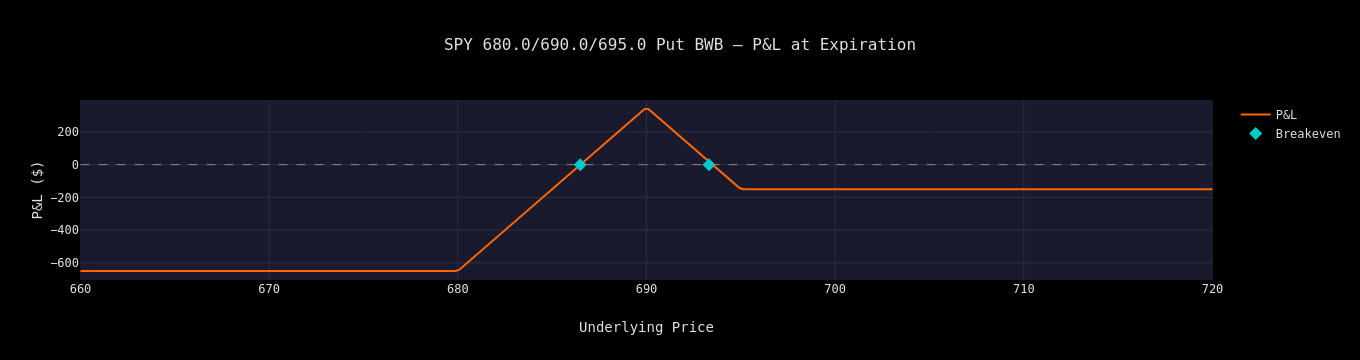

Max profit: $339.97
Max loss: $-650.00
Breakevens: ['$686.49', '$693.31']


In [4]:
import numpy as np

from options_analyzer.engine.payoff import PayoffCalculator
from options_analyzer.visualization.payoff_charts import plot_expiration_payoff

payoff_calc = PayoffCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)

# Price range around the position
center = float(body_strike)
price_range = np.linspace(center - 30, center + 30, 300)

# Compute expiration payoff
payoff = payoff_calc.expiration_payoff(bwb, price_range)

# Find breakevens (where payoff crosses zero)
sign_changes = np.where(np.diff(np.sign(payoff)))[0]
breakevens = [float(price_range[i]) for i in sign_changes]

fig = plot_expiration_payoff(
    price_range, payoff, breakevens=breakevens,
    title=f"{bwb.name} — P&L at Expiration",
)
fig.show()

print(f"Max profit: ${payoff.max():.2f}")
print(f"Max loss: ${payoff.min():.2f}")
print(f"Breakevens: {[f'${b:.2f}' for b in breakevens]}")

## 4. Theoretical P&L at Multiple DTEs

See how the P&L curve evolves as time passes — the smooth BSM curves converge to the hockey-stick at expiration.

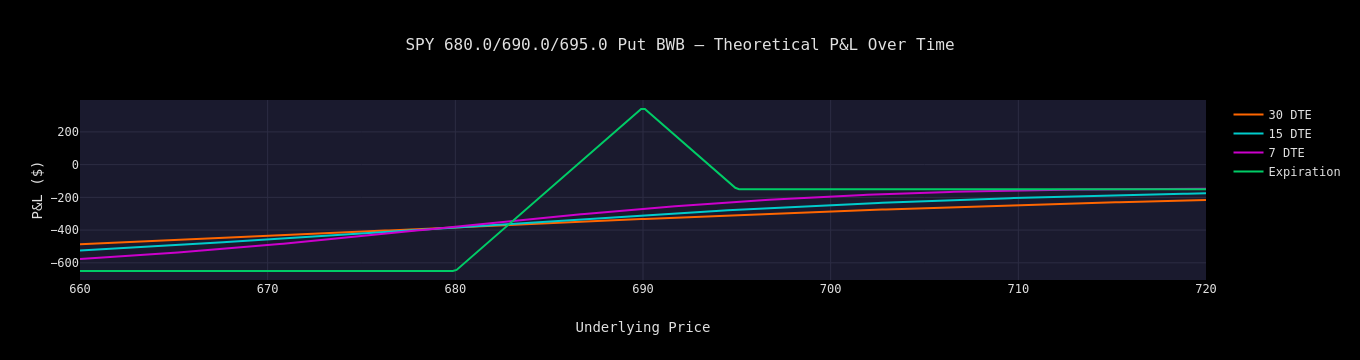

In [5]:
from options_analyzer.visualization.payoff_charts import plot_theoretical_pnl

# IVs for each leg (use a reasonable estimate)
ivs = {leg.contract.symbol: 0.20 for leg in bwb.legs}

dte_values = [30, 15, 7, 0]
pnl_by_dte = {}
for dte in dte_values:
    if dte == 0:
        pnl_by_dte["Expiration"] = payoff_calc.expiration_payoff(bwb, price_range)
    else:
        pnl_by_dte[f"{dte} DTE"] = payoff_calc.theoretical_pnl(
            bwb, price_range, ivs, float(dte)
        )

fig = plot_theoretical_pnl(
    price_range, pnl_by_dte,
    title=f"{bwb.name} — Theoretical P&L Over Time",
)
fig.show()

## 5. Greeks Analysis

Compute position-level Greeks using the BSM engine. The 2x2 subplot shows delta, gamma, theta, and vega sensitivity across the price range.

Position Greeks (current)
  Delta:     4.1687
  Gamma:    -0.0452
  Theta:   329.1894
  Vega:   -454.3830
  Rho:     319.0437


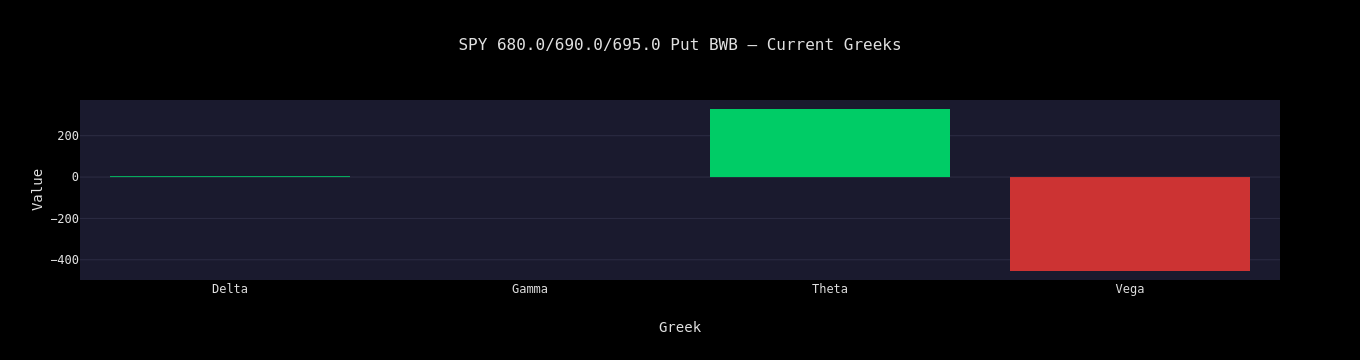

In [6]:
from options_analyzer.engine.greeks_calculator import GreeksCalculator
from options_analyzer.engine.position_analyzer import PositionAnalyzer
from options_analyzer.visualization.greeks_charts import (
    plot_greeks_vs_price,
    plot_greeks_summary,
)

greeks_calc = GreeksCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)
analyzer = PositionAnalyzer(greeks_calc)

# Current Greeks
pos_greeks = analyzer.position_greeks(bwb, float(spot_price), ivs)
agg = pos_greeks.aggregated

print("Position Greeks (current)")
print(f"  Delta: {agg.first_order.delta:>10.4f}")
print(f"  Gamma: {agg.first_order.gamma:>10.4f}")
print(f"  Theta: {agg.first_order.theta:>10.4f}")
print(f"  Vega:  {agg.first_order.vega:>10.4f}")
print(f"  Rho:   {agg.first_order.rho:>10.4f}")

# Greeks bar chart
fig = plot_greeks_summary(
    {"delta": agg.first_order.delta, "gamma": agg.first_order.gamma,
     "theta": agg.first_order.theta, "vega": agg.first_order.vega},
    title=f"{bwb.name} — Current Greeks",
)
fig.show()

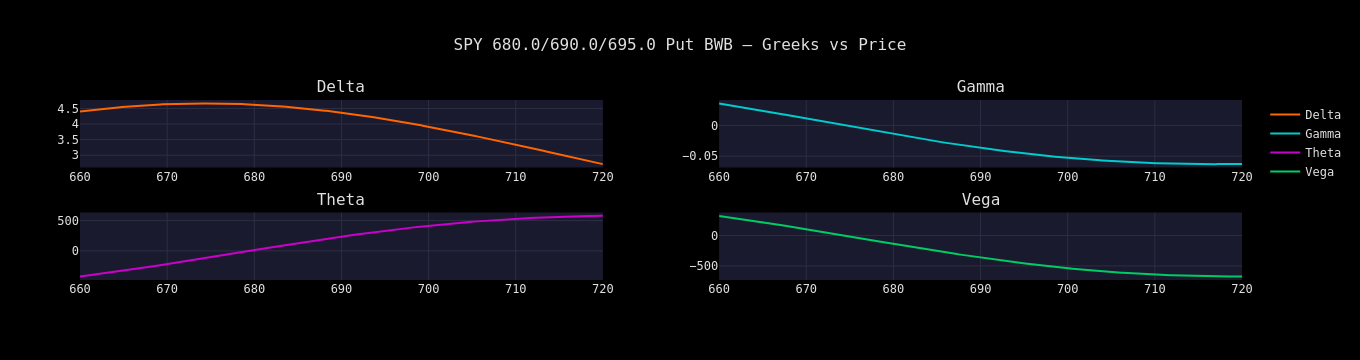

In [7]:
# Greeks vs price profiles (2x2 subplot)
greeks_profile = analyzer.greeks_vs_price(bwb, price_range, ivs)

fig = plot_greeks_vs_price(
    price_range, greeks_profile,
    title=f"{bwb.name} — Greeks vs Price",
)
fig.show()

## 6. Second-Order Greeks

These higher-order sensitivities reveal how the position behaves under changing conditions:

- **Vanna** (dDelta/dVol): How delta shifts when IV changes
- **Volga** (dVega/dVol): Convexity of the vega exposure
- **Charm** (dDelta/dTime): How delta drifts as time passes

Second-Order Greeks (current)
  Vanna: -17.692977
  Volga: 3993.246144
  Charm: -18.093830
  Veta:  1239.019996
  Speed:  -0.001630
  Color:   0.557442


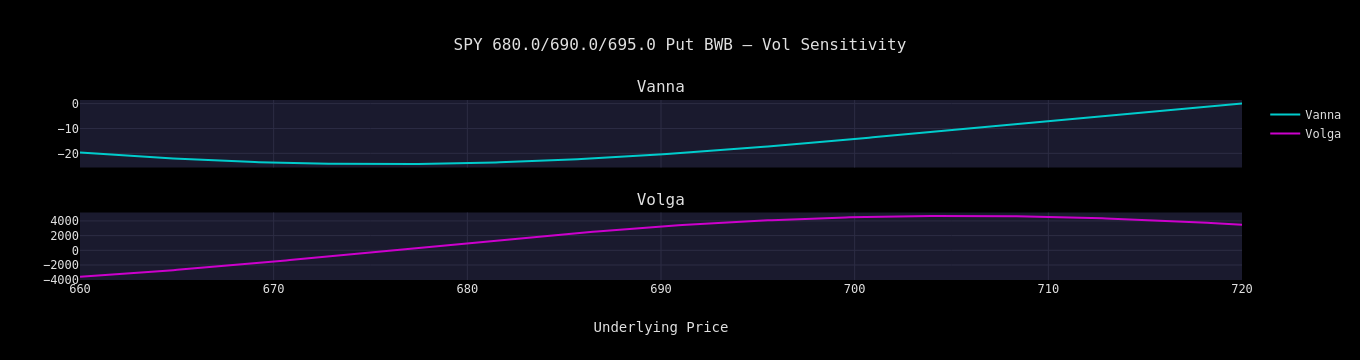

In [8]:
from options_analyzer.visualization.vol_charts import plot_vol_sensitivity

print("Second-Order Greeks (current)")
print(f"  Vanna: {agg.second_order.vanna:>10.6f}")
print(f"  Volga: {agg.second_order.volga:>10.6f}")
print(f"  Charm: {agg.second_order.charm:>10.6f}")
print(f"  Veta:  {agg.second_order.veta:>10.6f}")
print(f"  Speed: {agg.second_order.speed:>10.6f}")
print(f"  Color: {agg.second_order.color:>10.6f}")

# Vanna/Volga combined chart
fig = plot_vol_sensitivity(
    price_range,
    {"vanna": greeks_profile["vanna"], "volga": greeks_profile["volga"]},
    title=f"{bwb.name} — Vol Sensitivity",
)
fig.show()

## 7. Per-Leg Breakdown

See how each leg contributes to the overall position delta and gamma.

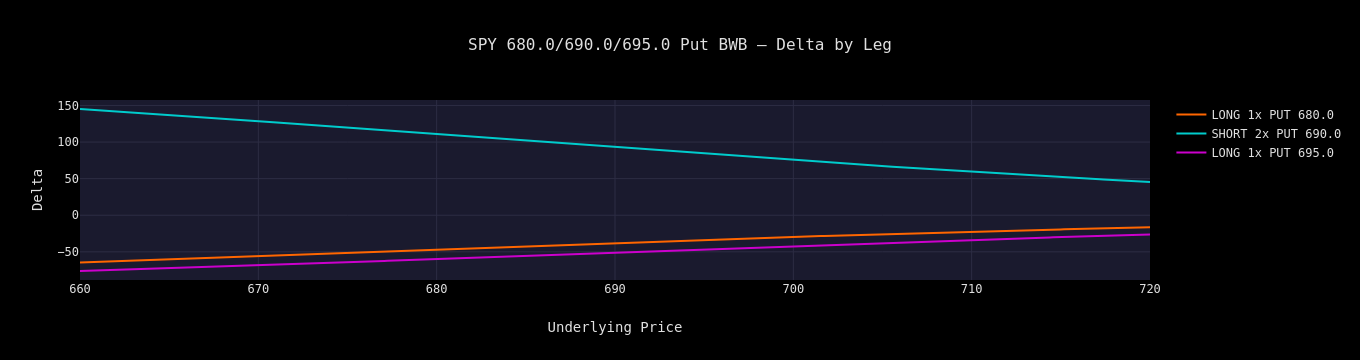

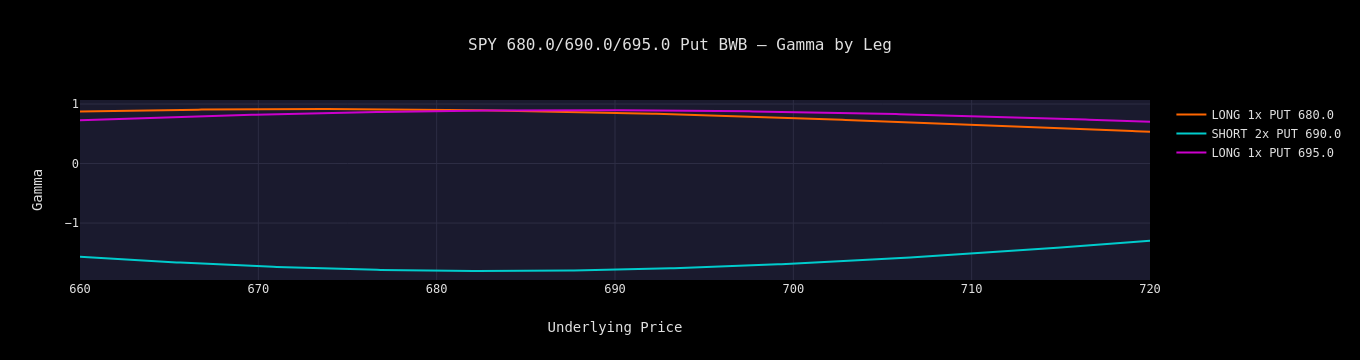

In [9]:
from options_analyzer.visualization.greeks_charts import plot_per_leg_greeks

# Compute per-leg Greeks across price range
per_leg_profiles: dict[str, dict[str, np.ndarray]] = {}
for leg in bwb.legs:
    label = f"{leg.side.value.upper()} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}"
    leg_greeks: dict[str, list[float]] = {"delta": [], "gamma": []}
    for S in price_range:
        T = max((leg.contract.expiration - date.today()).days / 365.0, 0.0)
        sigma = ivs[leg.contract.symbol]
        scale = leg.signed_quantity * leg.contract.multiplier
        full = greeks_calc.full(float(S), float(leg.contract.strike), T, sigma, leg.contract.option_type)
        leg_greeks["delta"].append(full.first_order.delta * scale)
        leg_greeks["gamma"].append(full.first_order.gamma * scale)
    per_leg_profiles[label] = {k: np.array(v) for k, v in leg_greeks.items()}

fig = plot_per_leg_greeks(price_range, per_leg_profiles, "delta", title=f"{bwb.name} — Delta by Leg")
fig.show()

fig = plot_per_leg_greeks(price_range, per_leg_profiles, "gamma", title=f"{bwb.name} — Gamma by Leg")
fig.show()

## 8. 3D P&L Surface

Interactive 3D surface showing P&L across both price and time dimensions. Rotate and zoom to explore.

In [ ]:
from options_analyzer.visualization.payoff_charts import plot_pnl_surface

dte_range = np.linspace(1, 45, 40)

surface = payoff_calc.pnl_surface(bwb, price_range, ivs, dte_range)

fig = plot_pnl_surface(
    price_range, dte_range, surface,
    title=f"{bwb.name} — P&L Surface",
)
fig.show()

## 9. Cleanup

In [ ]:
await tt_session.disconnect()
print("Session disconnected.")